In [1]:
%matplotlib inline
import os                       
import numpy as np              
import pandas as pd             
import torch                    
import matplotlib.pyplot as plt 
import torch.nn as nn           
from torch.utils.data import DataLoader  
from PIL import Image           
import torch.nn.functional as F 
import torchvision.transforms as transforms   
from torchvision.utils import make_grid       
from torchvision.datasets import ImageFolder  
from torchsummary import summary
import tensorflow as tf

In [2]:
train_dir = "archive/train"
valid_dir = "archive/valid"
test_dir = "archive/test"
diseases = os.listdir(train_dir)
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites_Two-spotted_spider_mite',

In [3]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class


,no. of images
Apple___Apple_scab,4032
Apple___Black_rot,3974
Apple___Cedar_apple_rust,2194
Apple___healthy,4016
Blueberry___healthy,3632
Cherry_(including_sour)___healthy,2472
Cherry_(including_sour)___Powdery_mildew,3366
Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot,3280
Corn_(maize)___Common_rust_,3814
Corn_(maize)___healthy,3718


In [4]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [5]:
img, label = train[2]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


Label :Apple___Apple_scab(0)


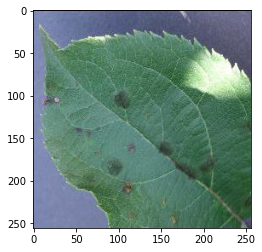

In [6]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
show_image(*train[12])    

In [7]:
random_seed = 7
torch.manual_seed(random_seed)

In [13]:
batch_size = 9
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

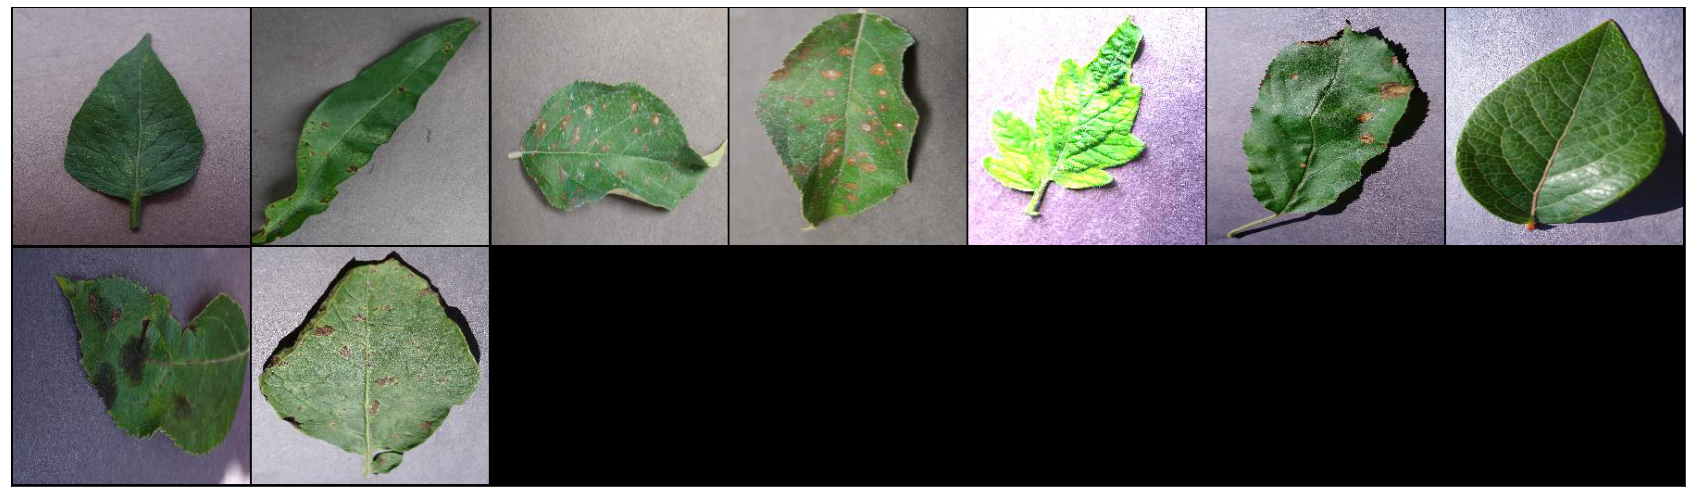

In [14]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=7).permute(1, 2, 0))
        break
show_batch(train_dl)         

In [10]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("CPU")

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [13]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        use_cuda = False
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x 

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                 
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)         
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} 
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


In [15]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)  
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb):
        use_cuda = False
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [16]:
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [18]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: total: 5min 16s
Wall time: 5min 8s


[{'val_loss': tensor(3.6378, device='cuda:0'), 'val_accuracy': tensor(0.0302)}]

In [20]:
torch.cuda.empty_cache()

In [19]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00280, train_loss: 0.6263, val_loss: 0.3604, val_acc: 0.8947
Epoch [1], last_lr: 0.00760, train_loss: 0.3756, val_loss: 0.4043, val_acc: 0.8803
Epoch [2], last_lr: 0.01000, train_loss: 0.4185, val_loss: 0.4961, val_acc: 0.8631
Epoch [3], last_lr: 0.00950, train_loss: 0.4128, val_loss: 0.5123, val_acc: 0.8538
Epoch [4], last_lr: 0.00812, train_loss: 0.3679, val_loss: 0.2843, val_acc: 0.9147
Epoch [5], last_lr: 0.00611, train_loss: 0.3064, val_loss: 0.2273, val_acc: 0.9307
Epoch [6], last_lr: 0.00389, train_loss: 0.2255, val_loss: 0.1470, val_acc: 0.9526
Epoch [7], last_lr: 0.00188, train_loss: 0.1494, val_loss: 0.0833, val_acc: 0.9738
Epoch [8], last_lr: 0.00050, train_loss: 0.0808, val_loss: 0.0545, val_acc: 0.9825
Epoch [9], last_lr: 0.00000, train_loss: 0.0411, val_loss: 0.0444, val_acc: 0.9869
CPU times: total: 1h 11min 41s
Wall time: 10h 40min 31s


In [21]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().numpy() for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

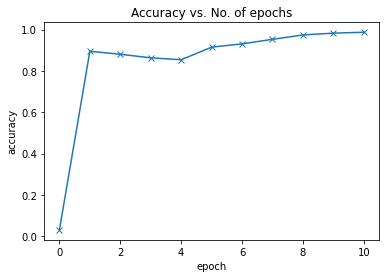

In [22]:
plot_accuracies(history)

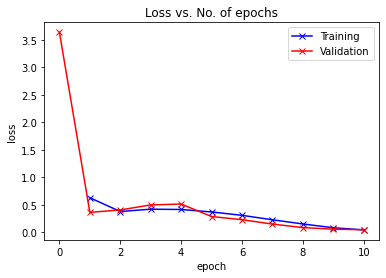

In [23]:
plot_losses(history)

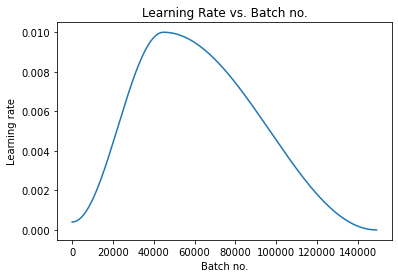

In [24]:
plot_lrs(history)

In [25]:
test_dir = "archive/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [26]:
test_images = sorted(os.listdir(test_dir + '/test'))
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [31]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)

    return train.classes[preds[0].item()]

Label: AppleCedarRust1.JPG , Predicted: Apple___Black_rot


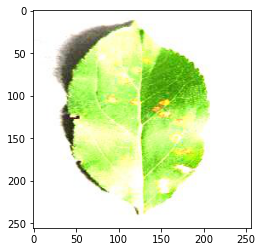

In [34]:
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [29]:
#PATH = 'Model/plant_model3.pt'
#torch.save(model, PATH)

PATH = 'Models/Final_Plant_Model.pth'  
torch.save(model.state_dict(), PATH)

In [30]:
model.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [21]:
PATH = 'Models/model.pth'  
#torch.load(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)

    return train.classes[preds[0].item()]


Label: TomatoEarlyBlight4.JPG , Predicted: Tomato___Early_blight


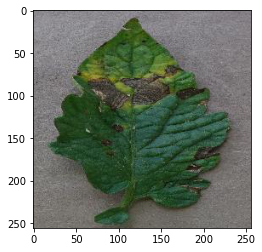

In [25]:
img, label = test[20]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[20], ', Predicted:', predict_image(img, model))

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms   
from torchvision.datasets import ImageFolder
import os
from PIL import Image

In [2]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet9(nn.Module):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)  
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb):
        use_cuda = False
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [3]:
test_dir = "archive/test"
train_dir = "archive/train"
diseases = os.listdir(train_dir)
test = ImageFolder(test_dir, transform=transforms.ToTensor())
test_images = sorted(os.listdir(test_dir + '/test'))
train = ImageFolder(train_dir, transform=transforms.ToTensor())
print(train.classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites_Two-spotted_spider_mite', 'Tomato___Target_Sp

In [4]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
#model = torch.load('Model/plant_model.pth')
model = torch.load('Model/plant_model2.pth', map_location=torch.device('cuda'))
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
'''''sampleimg = "archive/test/test/strawberrycommonleafspotbox198-033.JPG"
image = Image.open(sampleimg)
image = image.resize((355,355))
convert_tensor = transforms.ToTensor()
image = convert_tensor(image)'''

'\'\'sampleimg = "archive/test/test/strawberrycommonleafspotbox198-033.JPG"\nimage = Image.open(sampleimg)\nimage = image.resize((355,355))\nconvert_tensor = transforms.ToTensor()\nimage = convert_tensor(image)'

tensor([[-229.8430, -220.7595, -232.2036, -232.1685, -236.5299, -233.1435,
         -226.9642, -229.2021, -234.7672, -234.7771, -233.2270, -205.3447,
         -221.6642, -223.5796, -218.5037, -242.6313, -223.0209, -236.6228,
         -222.8136, -230.9815, -227.1955, -234.7676, -234.6566, -229.9153,
         -235.7626, -224.2224, -225.2734, -224.0721, -219.8943, -218.6529,
         -225.5401, -234.4817, -223.9639, -233.1794, -224.4431, -236.9057,
         -233.2707, -234.5579]], device='cuda:0', grad_fn=<AddmmBackward0>)
Label: GrapeBlackRot.JPG , Predicted: Grape___Black_rot


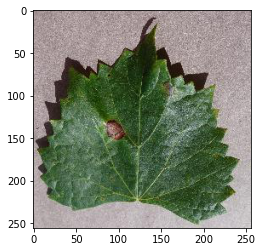

In [9]:
simg = 12

img, label = test[simg]
plt.imshow(img.permute(1, 2, 0))
xb = to_device(img.unsqueeze(0), dev)
yb = model(xb)
print(yb)
_, preds  = torch.max(yb, dim=1)
print('Label:', test_images[simg], ', Predicted:', train.classes[preds[0].item()])